# "Hvad er de politiske akser i Danmark?"
> "En analyse af hvordan danske politikere stemmer i folketinget"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Robin Engelhardt
- categories: [fastpages, jupyter, pca, folketinget]

Vi har for vane at opdele politik i højre- og venstrefløj. Hvorfor egentlig det? Den historiske begrundelse er meget simpel: det var sådan medlemmerne af den franske nationalforsamling placerede sig efter den franske revolution i 1789. Dem til højre i salen var loyale over for kongen og kirken, dem til venstre i salen støttede op om revolutionen, og i midten sad de moderate. På den måde undgik man de værste verbale forulempelser og [slåskampe](https://www.youtube.com/watch?v=GSXQ1ZgH7NQ).

{% include https://commons.wikimedia.org/wiki/File:Denmark_Folketinget_2020.svg#/media/Fil:Denmark_Folketinget_2020.svg align="right" width="200" height="200" %}

I dag forbinder man højre- og venstreføj med langt flere ideologiske grundholdninger end dem, der var fremherskende under den franske revolution. Opdelingen har dog overlevet, og selv når nye politiske partier kommer ind i de nationale parlamenter, forsøger man så vidt som muligt at placere dem i forhold til den klassiske højre-venstre opdeling - i Danmark for eksempel ved at placere De Radikale nogenlunde i midten, og Dansk Folkeparti helt ude til højre. 

In [2]:
#collapse-hide
import sys
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
plt.rcParams["font.family"] = "sans-serif"
PLOTS_DIR = 'plots'
%matplotlib inline

We start by calling the SQL server and write a query which is imported into a pandas dataframe. The period we want to investigate is given by the parameter periodid.

In [6]:
#hide
periodid = 151
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=HUM1006903\SQLEXPRESS;'
                      'Database=oda_20201103;'
                      #'Database=oda;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

sql_query = pd.read_sql_query('SELECT \
        oda.dbo.Afstemning.id AS bill, \
        oda.dbo.Sag.periodeid, \
        oda.dbo.Periode.titel AS period, \
        oda.dbo.Sag.titel AS titel, \
        oda.dbo.Sag.resume, \
        oda.dbo.Afstemning.konklusion AS conclusion, \
        oda.dbo.Sagstrin.dato AS date, \
        oda.dbo.Stemme.typeid AS vote, \
        oda.dbo.Aktør.fornavn, \
        oda.dbo.Aktør.efternavn, \
        oda.dbo.Aktør.biografi \
    FROM oda.dbo.Afstemning \
    JOIN oda.dbo.Stemme ON oda.dbo.Afstemning.id = oda.dbo.Stemme.afstemningid \
    JOIN oda.dbo.Aktør ON oda.dbo.Aktør.id = oda.dbo.Stemme.aktørid \
    JOIN oda.dbo.Sagstrin ON oda.dbo.Sagstrin.id = oda.dbo.Afstemning.sagstrinid \
    JOIN oda.dbo.Sag ON oda.dbo.Sag.id = oda.dbo.Sagstrin.sagid \
    JOIN oda.dbo.Periode ON oda.dbo.Sag.periodeid = oda.dbo.Periode.id \
    WHERE oda.dbo.Sag.periodeid='+str(periodid)+';', conn)

sql_query.head()

,bill,periodeid,period,titel,resume,conclusion,date,vote,fornavn,efternavn,biografi
0,7165,151,2019-20,Forslag til folketingsbeslutning om danske mil...,Med folketingsbeslutningen får regeringen Folk...,"Forslaget blev vedtaget. For stemte 106 (S, V,...",2019-10-24,1,Erling,Bonnesen,<member><url>/medlemmer/mf/e/erling-bonnesen</...
1,7165,151,2019-20,Forslag til folketingsbeslutning om danske mil...,Med folketingsbeslutningen får regeringen Folk...,"Forslaget blev vedtaget. For stemte 106 (S, V,...",2019-10-24,1,Morten,Bødskov,<member><url>/medlemmer/mf/m/morten-boedskov</...
2,7165,151,2019-20,Forslag til folketingsbeslutning om danske mil...,Med folketingsbeslutningen får regeringen Folk...,"Forslaget blev vedtaget. For stemte 106 (S, V,...",2019-10-24,1,Bent,Bøgsted,<member><url>/medlemmer/mf/b/bent-boegsted</ur...
3,7165,151,2019-20,Forslag til folketingsbeslutning om danske mil...,Med folketingsbeslutningen får regeringen Folk...,"Forslaget blev vedtaget. For stemte 106 (S, V,...",2019-10-24,1,Lennart,Damsbo-Andersen,<member><url>/medlemmer/mf/l/lennart-damsbo-an...
4,7165,151,2019-20,Forslag til folketingsbeslutning om danske mil...,Med folketingsbeslutningen får regeringen Folk...,"Forslaget blev vedtaget. For stemte 106 (S, V,...",2019-10-24,1,Louise Schack,Elholm,<member><url>/medlemmer/mf/l/louise-schack-elh...


In [43]:
sql_query.date.unique()

array(['2019-10-24T00:00:00.000000000', '2019-11-05T00:00:00.000000000',
       '2019-11-07T00:00:00.000000000', '2019-11-14T00:00:00.000000000',
       '2019-11-19T00:00:00.000000000', '2019-11-21T00:00:00.000000000',
       '2019-11-26T00:00:00.000000000', '2019-11-28T00:00:00.000000000',
       '2019-11-28T10:00:00.000000000', '2019-12-03T00:00:00.000000000',
       '2019-12-05T00:00:00.000000000', '2019-12-10T00:00:00.000000000',
       '2019-12-12T00:00:00.000000000', '2019-12-17T00:00:00.000000000',
       '2019-12-17T13:00:00.000000000', '2019-12-18T00:00:00.000000000',
       '2019-12-19T00:00:00.000000000', '2019-12-20T09:00:00.000000000',
       '2019-12-20T00:00:00.000000000', '2020-01-16T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-30T00:00:00.000000000',
       '2020-02-04T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-18T00:00:00.000000000', '2020-02-20

In [44]:
period_txt = str(sql_query['periodeid'].unique()[0]) + ': ' + sql_query.period.unique()[0]
period_txt

'151: 2019-20'

In [9]:
len(sql_query)

57817

Som man kan se, er der kun knap 58.000 rækker i dataframen (coronakrisen i 2020 betød at afstemninger efter 28. maj 2020 blev foretaget ved håndsoprækkelse og derfor ikke er inkluderet i databasen). Tabellen indeholder ikke nogen kolonne der angiver hvilket parti folketingsmedlemmerne tilhører. Det haves ikke i databasen. Eneste sted jeg kan se at man kan finde et folketingsmedlems partitilknytning i data er i "biografi"-kolonnen, som består af en masse XML tags. For at ekstrahere partinavnet, der er placeret mellem tagsene "party", bruger jeg bibliotekten xml.etree:

In [10]:
party = []
for bio_string in sql_query['biografi'].values:
    try:
        root = ET.fromstring(bio_string)
        for child in root.findall("./party"):
            party.append(child.text)
    except Exception as e:
        party.append(None)
        continue
sql_query['party'] = party

In [11]:
sql_query.party.unique()

array(['Venstre', 'Socialdemokratiet', 'Dansk Folkeparti',
       'Det Konservative Folkeparti', 'Enhedslisten', 'Liberal Alliance',
       'Radikale Venstre', 'Socialistisk Folkeparti', 'Nye Borgerlige',
       'Uden for folketingsgrupperne', 'Alternativet',
       'Sambandsflokkurin', 'Javnaðarflokkurin', 'Inuit Ataqatigiit',
       'Siumut'], dtype=object)

Lad os lige tjekke at alle partimedlemmer nu også tilhører et parti:

In [12]:
for index, row in sql_query.iterrows():
    if row.party == None:
        print(index, row['afstemning_id'], row['fornavn'], row['efternavn'], row['stemme'])

Næste skridt i rensningen af data består i at omkode de enkelte stemmer så deres numeriske værdi er normaliseret og kan bruges i analysen. Folketingets database har kodet dem sådan at et 1-tal betyder en stemme FOR, et 2-tal betyder IMOD, et 3-tal betyder FRAVÆR, og et 4-tal betyder "Hverken for eller imod". I stedet koder jeg dem sådan at 1 betyder FOR, -1 betyder "IMOD", og 0 betyder "hverken for eller imod. Desuden samler jeg for- og efternavn og beholder kun de kolonner, vi har brug for:

In [13]:
sql_query['name'] = sql_query[['fornavn', 'efternavn']].agg(' '.join, axis=1)

In [14]:
df = sql_query[['bill', 'titel', 'resume', 'conclusion', 'name', 'party', 'vote']]
df['vote'].replace(to_replace=2, value=-1, inplace=True)
df['vote'].replace(to_replace=4, value=0, inplace=True)
df.tail()

,bill,titel,resume,conclusion,name,party,vote
57812,7490,"Folketinget konstaterer, at det aftalte loft o...",,"Forslaget blev vedtaget. For stemte 54 (S, RV,...",Birgitte Bergman,Det Konservative Folkeparti,0
57813,7490,"Folketinget konstaterer, at det aftalte loft o...",,"Forslaget blev vedtaget. For stemte 54 (S, RV,...",Birgitte Vind,Socialdemokratiet,0
57814,7490,"Folketinget konstaterer, at det aftalte loft o...",,"Forslaget blev vedtaget. For stemte 54 (S, RV,...",Pernille Vermund,Nye Borgerlige,0
57815,7490,"Folketinget konstaterer, at det aftalte loft o...",,"Forslaget blev vedtaget. For stemte 54 (S, RV,...",Theresa Berg Andersen,Socialistisk Folkeparti,0
57816,7490,"Folketinget konstaterer, at det aftalte loft o...",,"Forslaget blev vedtaget. For stemte 54 (S, RV,...",Ruben Kidde,Radikale Venstre,0


In [15]:
Counter(df.vote)

Counter({1: 22567, -1: 11244, 3: 20853, 0: 3153})

Desværre viser det sig at der er rigtig mange fravær i folketinget (mange 3-taller), og manglende stemmer gør det vanskeligt at foretage en ordentlig PCA, fordi de gængs PCA-algoritmer ikke kan klare NaNs. Da der er mødepligt i folketinget, og alle folketingsmedlemmer SKAL stemme ved alle afstemninger, er det jo en mærkelig sag. Men det viser sig, at folketingets partier benytter sig af såkaldte 'clearingsaftaler', som er private aftaler mellem de forskellige folketingsgrupper. Aftalerne sikrer, at et antal folketingsmedlemmer fra hver partigruppe kan få 'fri' fra afstemningerne i folketingssalen, uden at der derved rokkes ved, hvilke partier som har flertal i Folketinget, eller ved, at der skal være mindst 90 medlemmer til stede, for at Folketinget er beslutningsdygtigt. Clearingaftalerne giver dermed mulighed for, at de politiske aktiviteter ikke går i stå, selv om der er møde og afstemninger i salen. Aftalerne giver plads til, at medlemmerne kan deltage i f.eks. politiske møder eller deltage i andre aktiviteter uden for Christiansborg, uden at afstemningerne i folketingssalen af den grund får et utilsigtet udfald.

I praksis indgås aftalerne typisk ved, at partigrupperne parvist aftaler for en hel folketingssamling, hvor mange medlemmer hver partigruppe kan 'cleare' hos hinanden - dvs. give lov til at blive væk fra afstemningerne, fordi den politiske modpart også beder et antal medlemmer blive væk. Når et medlem er clearet, stemmer medlemmet ikke i salen den pågældende dag. Hvordan clearingerne fordeles på medlemmer i partigrupperne kan veksle fra dag til dag, alt efter hvem der har behov for at være fri for at deltage i afstemningerne i salen. Det er typisk gruppesekretæren i den enkelte folketingsgruppe, som koordinerer fordelingen af clearingerne og sikrer, at man kan stille med det aftalte antal medlemmer ved eventuelle afstemninger. Det er også typisk gruppesekretæren, som tager kontakt til sin modpart i de andre partigrupper, hvis man pludselig har mandefald på grund af f.eks. sygdom eller lignende, og aftaler de nødvendige yderligere clearinger for en relevant periode. Det typiske mønster for clearingaftalerne er, at regeringspartierne clearer medlemmer med deres umiddelbare modpart. Dermed sikrer man lettest, at den politiske balance er bevaret på trods af clearingerne.

Efter en samtale med partisekretær Annette Lind (S), som i nuværende folketingssamling en den der sammen med Erling Bonnesen (V) koordinerer clearningsaftalerne for alle partierne, forstå jeg at hvis en person bliver clearet, så vil den person ALTID stemme ihht. partilinjen. Det vil sige at jeg kan skrive en funktion, der erstatter alle fravær med typetallet ("mode") for partiet for den givne afstemning. I tilfælde af at fravær er den hyppigste adfærd, vælger jeg i stedet den anden mest hyppige stemmetype. Og hvis alle medlemmer af et parti har været fraværende ved en afstemning (hvilket hyppigt sker for de grønlandske og færøske stemmer), sætter jeg dem til at være hverken for eller imod, dvs. til 0.


In [16]:
def get_most_frequent_vote(bill, party):
    df_ap = df[(df.bill == bill) & (df.party == party)]
    party_votes = df_ap.vote.values

    cnt = Counter(party_votes)
    mostfrequent_vote = cnt.most_common()[0][0]
    if mostfrequent_vote == 3:
        try:
            mostfrequent_vote = cnt.most_common()[1][0] # set the second most frequent vote as the most frequent one.
        except: # if all members of the party have been absent
            mostfrequent_vote = 0 # set their most frequent vote to be "abstain"  

    return mostfrequent_vote

for i, row in df.iterrows():
    if row['vote'] == 3:
        ifor_val = get_most_frequent_vote(row['bill'], row['party'])
        df.at[i,'vote'] = ifor_val
Counter(df.vote)

Counter({1: 35879, -1: 17432, 0: 4506})

For at få data i det rigtige format, bliver vi nød til at reorganisere tabellen således at rækkerne viser de enkelte folketingsmedlemmer, søjlerne de enkelte afstemninger, og selve cellerne indeholder så stemmerne. Vi kan bruge pivot-funtionen i python:

In [17]:
dp = df.pivot_table(index = ['name', 'party'], columns=['bill'], values=['vote'])
dp.dropna(inplace=True)
dp.columns = [col[1] for col in dp.columns] # get rid of the extra multicolumn "vote"
dp = dp.reset_index(level=['name', 'party']) # make the multiindex [name, party] into two columns
dp.head()

,name,party,7165,7166,7167,7168,7169,7170,7171,7172,...,7481,7482,7483,7484,7485,7486,7487,7488,7489,7490
0,Aaja Chemnitz Larsen,Inuit Ataqatigiit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aki-Matilda Høegh-Dam,Siumut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alex Vanopslagh,Liberal Alliance,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,Anders Kronborg,Socialdemokratiet,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Andreas Steenberg,Radikale Venstre,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Nu er vi sådan set klar til at lave pca'en, men lad os lige give partierne en farve, så vi kan kende forskel på dem på det resulterende plot:

In [18]:
# compute the color that each MP should be, based on their party. color codes are taken from https://www.dr.dk/om-dr/designmanager/temapakker/folketingsvalg-2019
color_dict = {
        'Enhedslisten' : '#E6801A',
        'Socialistisk Folkeparti'  : '#E07EA8',
        'Sambandsflokkurin' : '#41b6c4',
        'Javnaðarflokkurin' : '#67001f',
        'Socialdemokratiet' : '#A82721',
        'Siumut' : '#ef3b2c',
        'Radikale Venstre' : '#733280',
        'Inuit Ataqatigiit' : '#980043',
        'Det Konservative Folkeparti' : '#96B226',
        'Liberal Alliance'  : '#3FB2BE',
        'Venstre' : '#254264',
        'Dansk Folkeparti': '#EAC73E',
        'Uden for folketingsgrupperne' : '#737373',
        'nan' : 'black',
        'Alternativet' : '#2B8738',
        'Nye Borgerlige' : '#127B7F',
        'Kristendemokraterne' : '#8B8474',
        'Klaus Riskær Pedersen' : '#6C8BB8',
        'Stram Kurs' : '#998F4D', 
        'Nunatta Qitornai' : '#c51b8a',
        'Tjóðveldi' : '#a6d96a'
}
def party_color(x):
    return color_dict.get(str(x),'black')

colors = [party_color(x) for x in dp['party']]

In [20]:
num_folketingsmedlemmer = len(dp)
num_bills = len(dp.columns)-2
bills = dp.columns[2:num_bills+2]
dat = dp.iloc[:,2:num_bills+2]

pca = PCA(n_components=3)
pca.fit(dat)
xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(dat)[:,0] 
ys = pca.transform(dat)[:,1]

In [22]:
pca.explained_variance_, pca.explained_variance_ratio_

(array([61.99986167, 24.6393889 , 16.16983858]),
 array([0.45806589, 0.18204014, 0.11946561]))

Da disse principal components udelukkende er beregnet ud fra afstemningerne, og vi ikke har inkluderet nogen som helst information om partierne, giver x-aksen stadig et overraskende godt billede af hvad vi normalt forestiller os som den ideologiske højre-venstre akse i politik. Enhedslisten ligger yderst til venstre, og Dansk Folkeparti ligger yderst til højre (i hvert fald i årene før folketingsvalget i efteråret 2018), og i midten øverst ligger Socialdemokratiet. PCA er altså en "usuperviseret" metode, der beregnet afstanden mellem partierne som en kompleks blanding af, hvordan der blev stemt i de 323 afstemninger der blev registreret i folketingssamlingen 2019-2020 (Corona-pandemien betød at der i en periode mellem april til oktober 2020 ikke blev trykt på afstemningsknapperne i folketingssalen, hvorfor disse afstemninger ikke er registreret i databasen!).

Lad os prøve at se lidt nærmere på denne første komponent i PCA-analysen, som altså projicerer ned på en akse de største forskelle mellem de danske politikere, og som står for circa 60 % af variansen i data. Vi starter med at plotte et heat map for at se, hvilke afstemninger der har haft størst betydning for denne spredning.

In [23]:
xvector.shape

(323,)

Vi tilføjer et ekstra element så vi har 12x27 elementer, som vi så kan plotte ved at bruge matshow. Jeg har brugt en farvekode som angiver de afstemninger der er vigtige for højrefløjen med blå, og dem der er vigtige for venstrefløjen med rød.

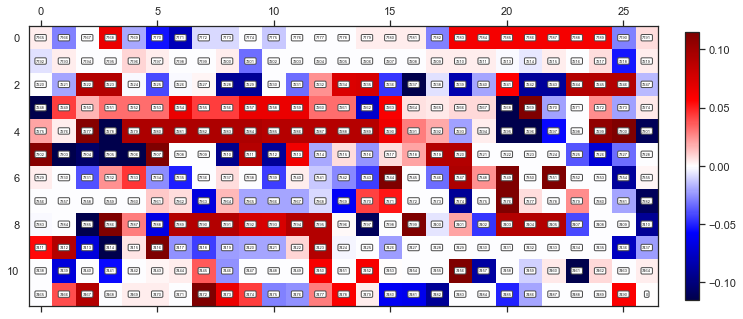

In [24]:
b = np.append(bills, [0])
b = b.reshape(12,27)
w = np.append(xvector, [0])
w = w.reshape(12,27)

fig, ax = plt.subplots(figsize=(12,8))
mesh = ax.matshow(w, cmap='seismic')
for (i, j), z in np.ndenumerate(b):
    ax.text(j, i, '{}'.format(z), ha='center', va='center', fontsize=4, bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.colorbar(mesh, ax=ax, fraction=0.02, pad=0.04)

In [25]:
ix_high = np.argsort(xvector)[-5:] # returns an array of sorted indexes of the components
ix_low = np.argsort(xvector)[:5] 
iy_high = np.argsort(yvector)[-5:] # returns an array of sorted indexes of the components
iy_low = np.argsort(yvector)[:5] 
ix_highest_and_lowest_comps = np.append(ix_high, ix_low)
iy_highest_and_lowest_comps = np.append(iy_high, iy_low)
ix_highest_and_lowest_comps, iy_highest_and_lowest_comps

(array([219, 248, 102, 133, 140, 293, 101, 128, 129, 136], dtype=int32),
 array([254, 226, 194, 195, 309, 239, 196, 159, 317, 174], dtype=int32))

(array([ 3.,  1.,  2.,  1., 10., 33., 18., 10., 39., 79., 28.,  4.,  3.,
        11.,  7., 58.,  9.,  1.,  5.,  1.]),
 array([-0.1492773 , -0.13476624, -0.12025517, -0.1057441 , -0.09123303,
        -0.07672197, -0.0622109 , -0.04769983, -0.03318876, -0.0186777 ,
        -0.00416663,  0.01034444,  0.0248555 ,  0.03936657,  0.05387764,
         0.06838871,  0.08289977,  0.09741084,  0.11192191,  0.12643298,
         0.14094404]),
 <BarContainer object of 20 artists>)

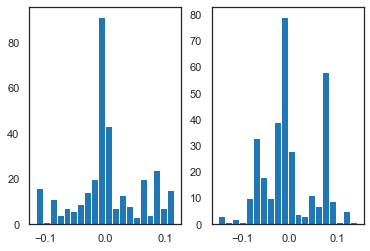

In [26]:
fig, ax = plt.subplots(1,2)
ax[0].hist(xvector, bins=20)
ax[1].hist(yvector, bins=20)

Men hvad med y-aksen? Den repræsenterer den næststørste afstand mellem stemmerne/partierne. Hvad står den for? Det er svært at sige, fordi denne komponent også er et mix af alle afstemnigner. Vi kan prøve at lave et heat-plot for at se, hvilke afstemninger har haft størst indflydelse på de enkelte komponenter: 

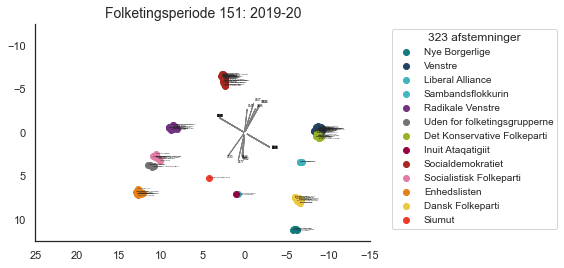

In [46]:
from adjustText import adjust_text
fig, ax = plt.subplots()

def get_arr_index_colors(color):
    # returns an array of indexes in the colors array corresponding to a certain party with color "color"
    col_mask = np.where(np.array(colors) == color,True,False)
    col_index = np.arange(0, len(colors))[col_mask]
    return col_index

for color in np.unique(colors):
    ix_color = get_arr_index_colors(color)
    ax.scatter(xs[ix_color], ys[ix_color], c = color, label = list(color_dict.keys())[list(color_dict.values()).index(color)])
    for i in ix_color:
        ax.annotate(dp.iloc[i]['name'], (xs[i], ys[i]), fontsize=2)

for i in ix_highest_and_lowest_comps:
# arrows project features as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs)*2, yvector[i]*max(ys)*2,
              color='grey', width=0.0005, head_width=0.005)
    texts = [plt.text(xvector[i]*max(xs)*2.2, yvector[i]*max(ys)*2.2,
             list(dat.columns.values)[i], color='black', fontsize=3)]

for i in iy_highest_and_lowest_comps:
# arrows project features as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs)*2, yvector[i]*max(ys)*2,
              color='grey', width=0.0005, head_width=0.005)
    plt.text(xvector[i]*max(xs)*2.2, yvector[i]*max(ys)*2.2,
             list(dat.columns.values)[i], color='black', fontsize=3)

plt.scatter(0,0, color='white', s=4, zorder=20)

adjust_text(texts)

lgd = ax.legend(title=str(num_bills)+' afstemninger', prop={'size': 10}, bbox_to_anchor=(1.05, 1))
ax.set_title('Folketingsperiode ' + period_txt, fontsize=14)

# invert the x-axis so that the "left wing" goes to the left and the "right wing" to the right. First grab a reference to the current axes and then set the xlimits to be the reverse of the current xlimits
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim([25,-15])
ax.set_ylim([12.5,-12.5])

#plt.tight_layout()


# Remember: save as pdf and transparent=True for Adobe Illustrator
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

plt.savefig(os.path.join(PLOTS_DIR, 'ft'+str(periodid)+'.png'), bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True, dpi=800)
plt.savefig(os.path.join(PLOTS_DIR, 'ft'+str(periodid)+'.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True, dpi=800)
sns.despine()